# ConV Network: Setup, training and evaluation

## Imports

In [61]:
import torch # version 1.3.1
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
import torch.nn.functional as F

import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F

import os
from os import listdir
from glob import glob
from datetime import datetime

import cv2

import matplotlib.pylab as plt

# data augmentation
from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter

# Split arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split

# remove if not needed because augmentation is already applied 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

import re

import random

import time
import copy

# INSTALL tqdm for jupyter lab:
# 1. pip install tqdm==4.36.1
# 2. pip install ipywidgets
# 3. jupyter nbextension enable --py widgetsnbextension
# 4. jupyter labextension install @jupyter-widgets/jupyterlab-manager (installed nodejs and npm needed)
from tqdm import tqdm_notebook as tqdm

#visualization at the end:
from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d

import pandas as pd

import numpy as np

import seaborn as sns
sns.set()

## Load necessary data from file system

In [78]:
loaded_train_df = pd.read_json("dataframes/final_train_df.json")
loaded_val_df = pd.read_json("dataframes/val_df.json")
loaded_test_df = pd.read_json("dataframes/test_df.json")

In [79]:
#show example file:
loaded_train_df

,patient_id,image_path,label,x,y
0,10258,data/breast-histopathology-images/IDC_regular_...,0,801,1151
1,10258,data/breast-histopathology-images/IDC_regular_...,0,801,951
2,10258,data/breast-histopathology-images/IDC_regular_...,0,851,651
3,10258,data/breast-histopathology-images/IDC_regular_...,0,601,951
4,10258,data/breast-histopathology-images/IDC_regular_...,0,1001,851
...,...,...,...,...,...
280827,9173,data/train_class1_augmented/9173_idx5_x2301_y1...,1,2301,1601
280828,13693,data/train_class1_augmented/13693_idx5_x551_y1...,1,551,1551
280829,13402,data/train_class1_augmented/13402_idx5_x1451_y...,1,1451,1001
280830,16165,data/train_class1_augmented/16165_idx5_x1401_y...,1,1401,1501


In [30]:
#for testing reasons:
sample_train = loaded_train_df.head(20000)
sample_val = loaded_val_df.head(3000)
sample_val

,patient_id,image_path,label,x,y
10430,9178,data/breast-histopathology-images/IDC_regular_...,0,1451,1551
10431,9178,data/breast-histopathology-images/IDC_regular_...,0,751,1051
10432,9178,data/breast-histopathology-images/IDC_regular_...,0,801,1301
10433,9178,data/breast-histopathology-images/IDC_regular_...,0,1551,451
10434,9178,data/breast-histopathology-images/IDC_regular_...,0,1801,501
...,...,...,...,...,...
17196,10259,data/breast-histopathology-images/IDC_regular_...,0,1301,401
17197,10259,data/breast-histopathology-images/IDC_regular_...,0,251,901
17198,10259,data/breast-histopathology-images/IDC_regular_...,0,2651,1601
17199,10259,data/breast-histopathology-images/IDC_regular_...,0,1401,501


## Setting up our Convolutional neural network

### Setting hyperparameters for our model:

In [83]:
BATCH_SIZE = 64 #bisher 32; beim model von letzter nacht 128
NUM_CLASSES = 2
LEARNING_RATE = 0.001 #beim model von letzter nacht 0.002
NUM_EPOCHS = 6 #vorher 8; beim letzten mal 5

In [84]:
#create directory for saving the model after training (only execute once):
#os.mkdir("saved_models")

OUTPUT_PATH = "saved_models/model_version_"
MODEL_EVAL_PATH = "saved_models/model_eval_"

In [85]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Transform the data

This allows us to manipulate our three datasets in a specified way.

In our first notebook on data preprocessing we already augmented the image patches in the training set with class 1 to boost their size. The goal was to reach an equal size for both classes 0 and 1. Here we still add another transformation on the training data (horizontal and vertical flipping plus rotation) to boost the overall size of our training data (now both classes).

Further we need to convert the input data to PyTorch tensor.

Additionally we add normalization. Neural networks train better when the input data is normalized, so that the data ranges from -1 to 1 or from 0 to 1. For that we need to compute the standard deviation and the mean of our training data and apply them to our train_transform. 
Note: for each input channel (here: 3) we need to apply the according mean and standard deviation.

The last two transformations count also for the validation and test datasets, whereas the first mentioned transformations only account for our training data.

#### Calculate mean and standard deviation of our three datasets

To hand the right parameters for mean and standard deviation to our my_transform function further down we first create three simple dataloader objects with our corresponding datasets to calculate the mean and standard deviation respectively.


In [33]:
#simple transform method; only for purpose of calculation mean and standard deviation
def transform_to_tensor():
    train_trans = [transforms.Resize((50, 50)), transforms.ToTensor()]
    return transforms.Compose(train_trans)

In [ ]:
#create test train_loader to calculate mean and standard dev on:
train_set = BreastCancerDataset(loaded_train_df, transform=transform_to_tensor())
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [34]:
mean = 0.
std = 0.
nb_samples = 0.

for _,data in enumerate(train_loader):
    images = data["image"].to(device)
    batch_samples = images.size(0) 
    data = images.view(batch_samples, images.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples
    
mean /= nb_samples
std /= nb_samples

In [37]:
print("Those are the mean values over our three dimensions in the train dataset:")
print(str(mean))
print()
print("Those are the standard deviation values over our three dims in train dataset:")
print(str(std))

Those are the mean values over our three dimensions in the train dataset:
tensor([0.7718, 0.6068, 0.7322])

Those are the standard deviation values over our three dims in train dataset:
tensor([0.0926, 0.1417, 0.1081])


In [39]:
#copied in values calculated above so we don't have to execute the two cells more often:
means_train = [0.7718, 0.6068, 0.7322]
standard_dev_train = [0.0926, 0.1417, 0.1081]

#### Calculate mean and standard deviation of our test data

In [40]:
#create test_loader to calculate mean and standard dev for the test dataset:
test_set = BreastCancerDataset(loaded_test_df, transform=transform_to_tensor())
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [41]:
test_mean = 0.
test_std = 0.
test_nb_samples = 0.

for _,data in enumerate(test_loader):
    images = data["image"].to(device)
    t_batch_samples = images.size(0) 
    data = images.view(t_batch_samples, images.size(1), -1)
    test_mean += data.mean(2).sum(0)
    test_std += data.std(2).sum(0)
    test_nb_samples += t_batch_samples
    
test_mean /= test_nb_samples
test_std /= test_nb_samples

In [43]:
print("Those are the mean values over our three dimensions in the test dataset:")
print(str(test_mean))
print()
print("Those are the standard deviation values over our three dims in test dataset:")
print(str(test_std))

Those are the mean values over our three dimensions in the test dataset:
tensor([0.8208, 0.6423, 0.7406])

Those are the standard deviation values over our three dims in test dataset:
tensor([0.0892, 0.1410, 0.1037])


In [ ]:
#copied in values:
#test_mean = [0.8208, 0.6423, 0.7406]
#test_std = [0.0892, 0.1410, 0.1037]

#### Calculate mean and standard deviation of our validation data

In [44]:
#create val_loader to calculate mean and standard dev for the validation dataset:
val_set = BreastCancerDataset(loaded_val_df, transform=transform_to_tensor())
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [45]:
val_mean = 0.
val_std = 0.
val_nb_samples = 0.

for _,data in enumerate(val_loader):
    images = data["image"].to(device)
    v_batch_samples = images.size(0) 
    data = images.view(v_batch_samples, images.size(1), -1)
    val_mean += data.mean(2).sum(0)
    val_std += data.std(2).sum(0)
    val_nb_samples += v_batch_samples
    
val_mean /= val_nb_samples
val_std /= val_nb_samples

In [46]:
print("Those are the mean values over our three dimensions in the validation dataset:")
print(str(val_mean))
print()
print("Those are the standard deviation values over our three dims in validation dataset:")
print(str(val_std))

Those are the mean values over our three dimensions in the validation dataset:
tensor([0.8031, 0.6202, 0.7270])

Those are the standard deviation values over our three dims in validation dataset:
tensor([0.0938, 0.1420, 0.1049])


In [ ]:
#copied in values:
#val_mean = [0.8031, 0.6202, 0.7270]
#val_std = [0.0938, 0.1420, 0.1049]

#### The following transform method will be used to manipulate our data sets for training and evaluation

Here we add the calculated values for mean and standard deviation for purpose of normalization from above.
For now we take the same values also for the validation and test data set, as we assume them to be very similar.

In [86]:
#transforms to apply to our data:
def my_transform(key="train_transform"):
    #boost class 1 in training set:
    train_transform = [transforms.Resize((50, 50)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomRotation(90), 
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.7718, 0.6068, 0.7322],std=[0.0926, 0.1417, 0.1081])]
    #change values:
    val_transform = [transforms.Resize((50, 50)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.8031, 0.6202, 0.7270],std=[0.0938, 0.1420, 0.1049])]
    
    test_transform = [transforms.Resize((50, 50)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.8208, 0.6423, 0.7406],std=[0.0892, 0.1410, 0.1037])]
        
    data_transforms = {'train_transform': transforms.Compose(train_transform),
                       'val_transform': transforms.Compose(val_transform),
                       'test_transform': transforms.Compose(test_transform)}
    return data_transforms[key]

### Here we create a class for our various datasets

This class will be used to create our various datasets and subsequently be passed to our data loader.

In [87]:
class BreastCancerDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.states = df
        self.transform=transform
      
    def __len__(self):
        return len(self.states)
        
    def __getitem__(self, idx):
        patient_id = self.states.patient_id.values[idx]
        x_coord = self.states.x.values[idx]
        y_coord = self.states.y.values[idx]
        image_path = self.states.image_path.values[idx] 
        image = Image.open(image_path)
        image = image.convert('RGB') # try to convert to YUV instead of RGB later
        
        if self.transform:
            image = self.transform(image)
         
        label = np.int(self.states.label.values[idx])
        return {"image": image,
                "label": label,
                "patient_id": patient_id,
                "x": x_coord,
                "y": y_coord}

### Putting our data sets (training, validation, testing) into a dataloader object

Here we create our datasets and apply the transformations defined above in our my_transform method.
After we befill our dataloader with the datasets.

The data loader object in PyTorch provides a number of features which are useful for us in consuming training data.
We can automatically shuffle the data. Further we can easily batch the data according to our defined BATCH_SIZE. PyTorch also enables us to load the data in parallel using multiprocessing. Data consumption becomes a lot more efficient this way.

As we say later on in the training loop the PyTorch data loader object can be used as an iterator, i.e. use "enumerate" to extract the data.

In [88]:
train_dataset = BreastCancerDataset(loaded_train_df, transform=my_transform(key="train_transform"))
val_dataset = BreastCancerDataset(loaded_val_df, transform=my_transform(key="val_transform"))
test_dataset = BreastCancerDataset(loaded_test_df, transform=my_transform(key="test_transform"))

In [89]:
image_datasets = {"train": train_dataset, "val": val_dataset, "test": test_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val", "test"]}

In [90]:
#check the size of our three different data sets:
dataset_sizes

{'train': 280832, 'val': 37886, 'test': 43313}

In [91]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [92]:
dataloaders = {"train": train_dataloader, "val": val_dataloader, "test": test_dataloader}

In [93]:
#meaning of number stored in dataloader: nr iterations for each epoch
print("Our training dataset has the size: " + str(dataset_sizes["train"]))
print("Divided by our batch_size of " + str(BATCH_SIZE) + " this leads to " + 
      str(len(dataloaders["train"])) + " iterations for each epoch while training.")
print()
print("Our validation data set has the size: " + str(dataset_sizes["val"]))
print("Divided by our batch_size of " + str(BATCH_SIZE) + " this leads to " + 
      str(len(dataloaders["val"])) + " iterations for each epoch for validation.")
print()
print("Our test data set has the size: " + str(dataset_sizes["test"]))
print("Divided by our batch_size of " + str(BATCH_SIZE) + " this leads to " + 
      str(len(dataloaders["test"])) + " iterations for each epoch for testing.")

Our training dataset has the size: 280832
Divided by our batch_size of 64 this leads to 4388 iterations for each epoch while training.

Our validation data set has the size: 37886
Divided by our batch_size of 64 this leads to 591 iterations for each epoch for validation.

Our test data set has the size: 43313
Divided by our batch_size of 64 this leads to 677 iterations for each epoch for testing.


### Define the architecture of our ConV neural network

Here we define the architecture of our model. For that we create our own class which inherits from the nn.Module super class from PyTorch.
For all functions that can be used from that super class see here: https://pytorch.org/docs/stable/nn.html

With the nn.Sequential function we define the various layers in our network.
Our network adapts a 3-layer CNN architecture employing 16, 32, 36.992 and 128 neurons for our first two convolutional layers and the two fully-connected layers respectively. We chose these numbers as we planned to orient our approach at the architecture chosen in this paper: 2014 ...
Note: We had to add an additional fully-connected layer with 36.992 neurons. (Name reason TODO)




In the paper they chose a fixed convolutional kernel of size 8x8 and a pool kernel of size 2x2.


We used ReLu as activation functions and maxPooling at the end of our convolutional layers to down-sample our data after each convolution by reducing the effective image size.
Further we applied dropout to minimize the chance of overfitting, improve generalization and also improve the training time. In order to let the dropout layer do its job we have to flatten the input to that layer in the forward function. For further reasoning see here: https://towardsdatascience.com/dropout-on-convolutional-layers-is-weird-5c6ab14f19b2


### TODO's:
- Grund warum 2. fully connected layer nötig? haben wir gerade ein 4-layer oder ein 3-layer netz?
    (wegen anwendung von dropout und dessen reshaping/flattening nötig? irgendwie so war es ja..)
- vielleicht genauer begründen warum wir ReLu nehmen, etc.

#### General method to calculate either the output size, the convolutional filter (kernel) size, the stride, or pooling:

<math display="block">
  <msub>
    <mi>W</mi>
    <mrow class="MJX-TeXAtom-ORD">
      <mi>o</mi>
      <mi>u</mi>
      <mi>t</mi>
    </mrow>
  </msub>
  <mo>=</mo>
  <mfrac>
    <mrow>
      <mo stretchy="false">(</mo>
      <msub>
        <mi>W</mi>
        <mrow class="MJX-TeXAtom-ORD">
          <mi>i</mi>
          <mi>n</mi>
        </mrow>
      </msub>
      <mo>&#x2013;</mo>
      <mi>F</mi>
      <mo>+</mo>
      <mn>2</mn>
      <mi>P</mi>
      <mo stretchy="false">)</mo>
    </mrow>
      <mi>/</mi>  
    <mi>S</mi>
  </mfrac>
  <mo>+</mo>
  <mn>1</mn>
</math>

- W in = width of the input
- F = filter or kernel size
- P = padding
- S = stride
- W out = output size

The same formula accounts for the calculation of the height of the input and output, as we have the case of a symmetrical image size (height = width) and we also decided to take an equal number for height and width of the filter/kernel.

### TODO 
- maybe show calculation why we chose which number for kernel size/stride etc or just argument with numbers from paper as done so far

In [94]:
class ThreeLayerCNN(nn.Module):
    def __init__(self):
        # ancestor constructor call
        super(ThreeLayerCNN, self).__init__()
        
        # Conv Layer 1
        self.convLayer1 = nn.Sequential( # TODO: calculate stride, padding
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=8, stride=1),
            nn.BatchNorm2d(16), #NEU
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1))
        
        # Conv Layer 2
        self.convLayer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=8, stride=1),
            nn.BatchNorm2d(32), #NEU
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1))
            
        # Dropout: avoid overfitting. only for training
        self.drop_out = nn.Dropout()        
        
        #Fully Connected Layer
      #  self.fc1 = nn.Linear(128, 2) #      32, 34, 34 
        self.fc1 = nn.Linear(32*34*34, 128)
       # self.fc1 = nn.Linear(32*1*1, 128) # 32,1,1
        self.fc2 = nn.Linear(128, 2)
    
    
    def forward(self, x):
        out = self.convLayer1(x)
        #print("after conv1: " + str(out.shape))
        out = self.convLayer2(out)
        #print("after conv2: " + str(out.shape)) # after conv2: torch.Size([32, 32, 34, 34])
        # what does reshape do? -> flatten. why befor drop_out?
       # out = out.reshape(out.size(0), -1) 
       # out = out.view(-1, 128)
        out = out.view(-1, 32*34*34)
       # out = out.view(-1, 32*1*1)
        out = self.drop_out(out)
        #print("after dropout: " + str(out.shape))
        out = self.fc1(out)
        #print("after fc1: " + str(out.shape))
        out = self.fc2(out)
        #print("after fc2: " + str(out.shape))
        
        return out      

### Define our model

In [95]:
model = ThreeLayerCNN().to(device)

In [96]:
print(model)

ThreeLayerCNN(
  (convLayer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(8, 8), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (convLayer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(8, 8), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=36992, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


### Defining a loss function and an optimizer

Before we train the model, we have to define our loss function and optimizer.
We used PyTorch’s CrossEntropyLoss() function.

Notice: So far we haven't defined a softmax activation for the final fully-connected classification layer above.
The reason is that the crossentropy function from PyTorch combines both a softmax activation together with a cross entropy loss function.

After that we define an adam optimizer, which we pass our parameters that we want the optimizer to train. We also supply our learning rate.

In [97]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Decay LR by a factor of 0.1 every epoch
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

## Model training

In [51]:
#number of iterations:
total_step = len(train_dataloader) 

#for tracking the loss and accuracy of our model:
loss_list = []
acc_list = []

for epoch in range(NUM_EPOCHS):
  
    for i, data in enumerate(train_dataloader):
        images = data["image"].to(device)
        labels = data["label"].to(device)        
        
        # run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        
        # run the backward pass (backpropagation) and perform adams optimization as specified above
        optimizer.zero_grad() # here the gradients are zeroed before backprop starts
        loss.backward() # calcs the gradients
        optimizer.step() #adam optimizer training step
        
        #track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1) #richtig??
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)
        
        #print out current results after another 100 iterations are done:
        if (i+1) % 100 == 0: # TODO: change back to 100
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%' 
                   .format(epoch+1, NUM_EPOCHS, i+1, total_step, loss.item(), (correct / total) * 100))

            
#Save our model to new directory
#to keep track of different models created we append a timestamp to the model name
time = datetime.now(tz=None)
timestamp = str(time.year) + "_" + str(time.month) + "_" + str(time.day) + "_" + str(time.hour)+ ":" + str(time.minute)+ ":" + str(time.second)

new_model_new_dir = OUTPUT_PATH + timestamp
os.mkdir(new_model_new_dir)
curr_model_output_path = new_model_new_dir + "/model_version_" + timestamp + ".pth"
torch.save(model.state_dict(), curr_model_output_path)


Epoch [1/2], Step [100/312], Loss: 0.3119, Accuracy: 84.38%
Epoch [1/2], Step [200/312], Loss: 0.3614, Accuracy: 82.81%
Epoch [1/2], Step [300/312], Loss: 0.3453, Accuracy: 85.94%
Epoch [2/2], Step [100/312], Loss: 0.3614, Accuracy: 87.50%
Epoch [2/2], Step [200/312], Loss: 0.3334, Accuracy: 84.38%
Epoch [2/2], Step [300/312], Loss: 0.2366, Accuracy: 90.62%


## Verbindung train und val:

In [50]:
#dataloaders = {"train": train_dataloader, "val": val_dataloader, "test": test_dataloader}
datasets_length = {"train": len(train_dataloader), "val": len(val_dataloader), "test": len(test_dataloader)}
phases = ["train", "val"]

#number of iterations:
total_step = len(train_dataloader) 

#for tracking the loss and accuracy of our model:
loss_list = []
acc_list = []

for epoch in range(NUM_EPOCHS):
      for phase in phases:
            if phase == "train":
                #optimizer = scheduler(optimizer, epoch)
                model.train()
            else:
                model.eval()
            
            running_loss = 0.

            for i, data in enumerate(dataloaders[phase]):
                images = data["image"].to(device)
                labels = data["label"].to(device)        

                # run the forward pass
                outputs = model(images)
                #calculate loss between predicted and labels:
                loss = criterion(outputs, labels)
                loss_list.append(loss.item())

                # run the backward pass (backpropagation) and perform adams optimization as specified above
                optimizer.zero_grad() # here the gradients are zeroed before backprop starts
                
                if phase == "train":
                    loss.backward() # calcs the gradients
                    optimizer.step() #adam optimizer training step
                
                running_loss += loss.item()

                #track the accuracy
                total = labels.size(0)
                _, predicted = torch.max(outputs.data, 1) #richtig??
                correct = (predicted == labels).sum().item()
                acc_list.append(correct / total)

                #print out current results after another 100 iterations are done:
                if (i+1) % 10 == 0: # TODO: change back to 100
                    print ('Phase {}, Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%' 
                           .format(phase, epoch+1, NUM_EPOCHS, i+1, total_step, loss.item(), (correct / total) * 100))

            #epoch loss zeug:
            epoch_loss = running_loss / datasets_length[phase]
            print('{} Epoch loss: {:.4f}'.format(phase, epoch_loss))
            
#Save our model to new directory
#to keep track of different models created we append a timestamp to the model name
time = datetime.now(tz=None)
timestamp = str(time.year) + "_" + str(time.month) + "_" + str(time.day) + "_" + str(time.hour)+ ":" + str(time.minute)+ ":" + str(time.second)

new_model_new_dir = OUTPUT_PATH + timestamp
os.mkdir(new_model_new_dir)
curr_model_output_path = new_model_new_dir + "/model_version_" + timestamp + ".pth"
torch.save(model.state_dict(), curr_model_output_path)


Phase train, Epoch [1/2], Step [10/312], Loss: 0.2389, Accuracy: 92.19%
Phase train, Epoch [1/2], Step [20/312], Loss: 0.3383, Accuracy: 89.06%
Phase train, Epoch [1/2], Step [30/312], Loss: 0.3550, Accuracy: 87.50%
Phase train, Epoch [1/2], Step [40/312], Loss: 0.4550, Accuracy: 85.94%
Phase train, Epoch [1/2], Step [50/312], Loss: 0.3184, Accuracy: 90.62%
Phase train, Epoch [1/2], Step [60/312], Loss: 0.2823, Accuracy: 87.50%
Phase train, Epoch [1/2], Step [70/312], Loss: 0.3356, Accuracy: 84.38%
Phase train, Epoch [1/2], Step [80/312], Loss: 0.2563, Accuracy: 92.19%
Phase train, Epoch [1/2], Step [90/312], Loss: 0.3465, Accuracy: 89.06%
Phase train, Epoch [1/2], Step [100/312], Loss: 0.3539, Accuracy: 82.81%
Phase train, Epoch [1/2], Step [110/312], Loss: 0.4632, Accuracy: 75.00%
Phase train, Epoch [1/2], Step [120/312], Loss: 0.3961, Accuracy: 82.81%
Phase train, Epoch [1/2], Step [130/312], Loss: 0.2818, Accuracy: 87.50%
Phase train, Epoch [1/2], Step [140/312], Loss: 0.5584, Accu

# Finaler Versuch??

In [98]:
## Neuer versuch nach pytorch tutorial:
phases = ["train", "val"]


def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_f1 = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            #initialize tp etc. with zero:
            tn, fn, fp, tp = 0, 0, 0, 0

            # Iterate over data
            for i, data in enumerate(dataloaders[phase]):
                inputs = data["image"].to(device)
                labels = data["label"].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                 
                        
                #calculate true positives etc.:
                for pred, lab in zip(predictions, labels):
                    if(pred == 0 and lab == 0):
                        tn += 1
                    if(pred == 0 and lab == 1):
                        fn += 1
                    if(pred == 1 and lab == 0):
                        fp += 1
                    if(pred ==1 and lab ==1):
                        tp += 1
                
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)
            
                correct = (predictions == labels).sum().item()
                total = labels.size(0)
                nr_iterations = len(dataloaders[phase])
            
                #print out current results after another 100 iterations are done:
                if (i+1) % 10 == 0: # TODO: change back to 100
                    print ('Phase {}, Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%' 
                           .format(phase, epoch+1, NUM_EPOCHS, i+1, nr_iterations, loss.item(), (correct / total) * 100))
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            #calculate precision, recall and f1:
            epoch_precision = tp / (tp + fp)
            epoch_recall = tp / (tp + fn)
            epoch_f1 = 2 * ((epoch_precision * epoch_recall) / (epoch_precision + epoch_recall))

            print('{} Loss: {:.4f} Acc: {:.4f} Precision: {:.4f} Recall: {:.4f} F1: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_precision, epoch_recall, epoch_f1))

            # deep copy the model (bisher mit accuracy)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
            #    best_model_wts = copy.deepcopy(model.state_dict())
            
            #alternativ mit f1:
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val F1: {:4f}'.format(best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [77]:
#training ausführen:

model = train_model(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS)

#Save our model to new directory
#to keep track of different models created we append a timestamp to the model name
time = datetime.now(tz=None)
timestamp = str(time.year) + "_" + str(time.month) + "_" + str(time.day) + "_" + str(time.hour)+ ":" + str(time.minute)+ ":" + str(time.second)

new_model_new_dir = OUTPUT_PATH + timestamp
os.mkdir(new_model_new_dir)
curr_model_output_path = new_model_new_dir + "/model_version_" + timestamp + ".pth"
torch.save(model.state_dict(), curr_model_output_path)

Epoch 0/1
----------
Phase train, Epoch [1/2], Step [10/312], Loss: 0.3876, Accuracy: 81.25%
Phase train, Epoch [1/2], Step [20/312], Loss: 0.3374, Accuracy: 84.38%
Phase train, Epoch [1/2], Step [30/312], Loss: 0.4919, Accuracy: 75.00%
Phase train, Epoch [1/2], Step [40/312], Loss: 0.3496, Accuracy: 84.38%
Phase train, Epoch [1/2], Step [50/312], Loss: 0.2629, Accuracy: 85.94%
Phase train, Epoch [1/2], Step [60/312], Loss: 0.3837, Accuracy: 81.25%
Phase train, Epoch [1/2], Step [70/312], Loss: 0.4603, Accuracy: 79.69%
Phase train, Epoch [1/2], Step [80/312], Loss: 0.2534, Accuracy: 92.19%
Phase train, Epoch [1/2], Step [90/312], Loss: 0.3710, Accuracy: 84.38%
Phase train, Epoch [1/2], Step [100/312], Loss: 0.3186, Accuracy: 87.50%
Phase train, Epoch [1/2], Step [110/312], Loss: 0.3609, Accuracy: 89.06%
Phase train, Epoch [1/2], Step [120/312], Loss: 0.3066, Accuracy: 85.94%
Phase train, Epoch [1/2], Step [130/312], Loss: 0.4145, Accuracy: 89.06%
Phase train, Epoch [1/2], Step [140/312

KeyboardInterrupt: 

#### Save loss and accuracy from training to same directory as model above

In [180]:
#save loss and acc after training: 
#TODO: compare later with results from testing?

len_loss = len(loss_list) # nrEpoch * nrIterationsPerEpoch
#print(len_loss)

#create pandas df with loss and acc from training:
loss_acc_stats = pd.DataFrame(loss_list, columns=["train_loss"])
loss_acc_stats["train_acc"] = acc_list
new_model_new_dir

path = new_model_new_dir + "/loss_acc_stats.json"
loss_acc_stats.to_json(path)

#loss_acc_stats

#### Load former loss and accuracy in again (if needed)

In [181]:
#load loss_acc_stats in again if needed:
loaded_loss_acc_stats = pd.read_json(path)
loaded_loss_acc_stats.shape

(21940, 2)

### Visualization of training loss and accuracy

Text(0, 0.5, 'Train Accuracy')

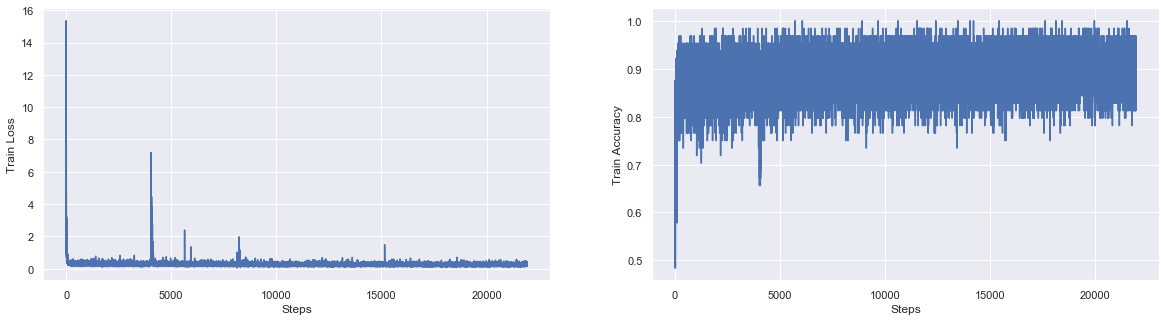

In [182]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(np.array(loaded_loss_acc_stats["train_loss"]))
ax[1].plot(np.array(loaded_loss_acc_stats["train_acc"]))
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Train Loss")
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Train Accuracy")

## Test our model

### First load in the model from directory

When the training is done we can just upload our saved model from the directory we saved it to

In [39]:
#TODO ist alles wichtige in dem model drin? 
#see: https://pytorch.org/tutorials/beginner/saving_loading_models.html


#JUST FOR NOW:
curr_model_output_path = "saved_models/model_version_2020_1_11_22:12:11/model_version_2020_1_11_22:12:11.pth"

#test with current model:
model_to_test = ThreeLayerCNN()
model_to_test.load_state_dict(torch.load(curr_model_output_path))

<All keys matched successfully>

### TODO was ist mit unseren validierungsdaten? noch nicht genutzt bisher

### Test accuracy on the test image patches

Setting the model to evaluation mode by calling model.eval() disables drop-out and batch normalization layers in our model.
The function call torch.no_grad() on the other hand disables the autograd functionality in our model. It is not needed for evaluation. Further it speeds up the computations.

In [43]:
#set the model to evaluation mode
model_to_test.eval()

confusion_matrix = torch.zeros(2, 2)

with torch.no_grad():
    correct = 0
    tn = 0 
    fn = 0 
    fp = 0 
    tp = 0 
    total = 0
    
    #nur für jetzt:
    a = 0
    d = 0
    
    #for images, labels in test_dataloader:
    for i, data in enumerate(test_dataloader):
        images = data["image"].to(device)
        labels = data["label"].to(device)
        
        outputs = model_to_test(images)
        if(a == 0):
            print("outputs.data: " + str(outputs.data))
            print("softmax: ")
            print(nn.functional.softmax(outputs)) # HIER KOMMEN DIE WAHRSCHEINLICHKEITEN RAUS
            a = 1
        _, predicted = torch.max(outputs.data, 1)
        if(d == 0):
            print("torch.max(outputs.data, 1): " + str(torch.max(outputs.data, 1)))
            print("predicted: " + str(predicted))
            d = 1
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        #iterate over predicted and labels to get tp, fp, tn, tf:
        for pred, lab in zip(predicted, labels):
            if(pred == 0 and lab == 0):
                tn += 1
            if(pred == 0 and lab == 1):
                fn += 1
            if(pred == 1 and lab == 0):
                fp += 1
            if(pred ==1 and lab ==1):
                tp += 1
        
            #befill confusion_matrix:
            confusion_matrix[lab.long(), pred.long()] += 1
        
    
    print('Anzahl Testdaten gesamt: ' + str(total))
    print('Richtig vorhergesagt (TN und TP): ' + str(correct))
    print('Falsch vorhergesagt (FN und FP): ' + str(total - correct))
    print('True negative: ' + str(tn))
    print('False negative: ' + str(fn))
    print('False positive: ' + str(fp))
    print('True positive: ' + str(tp))
    print('Test Accuracy of the model on the 43313 test image patches: {} %'.format((correct / total) * 100))

# Save the model checkpoint
#curr_model_eval_path = new_model_new_dir + "/model_eval_" + timestamp + ".ckpt"
#torch.save(model_to_test.state_dict(), curr_model_eval_path)

outputs.data: tensor([[ 1.1094, -0.1617],
        [ 0.4206,  0.1669],
        [-1.6465,  2.0683],
        [ 1.4617, -1.7075],
        [-0.0880, -0.6063],
        [-0.2227, -0.6956],
        [ 2.1606, -2.3986],
        [-0.1660,  1.9530],
        [ 1.3142, -1.3870],
        [ 0.5143, -0.2460],
        [ 0.9425, -0.9261],
        [-0.8838,  0.6661],
        [ 0.3153, -1.4051],
        [ 7.5904, -2.7344],
        [-0.0766, -0.1923],
        [ 0.9657,  0.1103],
        [-0.5024,  1.3522],
        [ 0.0676, -1.9019],
        [-0.7425,  0.8384],
        [ 0.2795, -0.5575],
        [ 2.0539, -2.5005],
        [ 1.8353, -2.5913],
        [ 1.9205, -0.0184],
        [ 4.5180, -3.0931],
        [ 2.0695, -1.3346],
        [ 2.4619, -0.4327],
        [-0.8207, -1.3976],
        [ 0.6544,  0.5012],
        [-0.5590,  0.9989],
        [ 0.7680, -1.1091],
        [ 1.2894, -0.8370],
        [-0.1474,  0.0534],
        [-1.0354,  1.0898],
        [ 0.2773,  0.8918],
        [ 1.4618, -1.3260],
      

/home/laureslinuxes/.local/share/virtualenvs/BreastCancer-xbvsc4Xo/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: 

### Confusion matrix

In [185]:
print(confusion_matrix)

tensor([[24930.,  5335.],
        [ 3195.,  9853.]])


In [186]:
#versuch umwandlung in numpy array, dann in pandas dataframe für einen plot (bisher nicht erfolgreich)
matrix_as_arr = np.array(confusion_matrix)

matrix_as_df = pd.DataFrame({'Predicted: 0': matrix_as_arr[:,0], 'Predicted: 1': matrix_as_arr[:,1]})
matrix_as_df

,Predicted: 0,Predicted: 1
0,24930.0,5335.0
1,3195.0,9853.0


## TODO vielleicht richtig visualisieren oder too much? mir egal

### Calculate precision and recall for our test results

In [187]:
#precision
precision = tp / (tp + fp) #precision denominator: total predicted positive

#recall
recall = tp / (tp + fn) #recall denominator: total actual positive

print("Precision:")
print()
print("Precision tells us how many of the overall predicted positive are actually true positive ones. Precision is a good measure to tell us if the cost of false positive is high.")
print("For our case: From the " + str(tp + fp) + " image patches that we predicted as having IDC, only " +
      str(tp) + " patches actually contain IDC.")
print("Hence, only " + str(precision * 100) + "% are being predicted right.")
print("Depending on which patches belong to which image from which patient, we would have told quite some patients that they have IDC, even though they don't have it.")
print()
print()
print("Recall:")
print()
print("Recall calculates how many of the actual positives from our model we captured through labeling them as positive. This metric tells us whether there is a high cost associated with false negative.")
print("For our case: From all the " + str(tp + fn) + " image patches that actually show IDC, we only predicted " +
     str(tp) + " image patches correctly.")
print("Hence, " + str(recall * 100) + "% are being predicted right.")
print("Again depending on which patches belong to which image from which patient we would have told some patients they don't have IDC even though they have breast cancer.")


Precision:

Precision tells us how many of the overall predicted positive are actually true positive ones. Precision is a good measure to tell us if the cost of false positive is high.
For our case: From the 15188 image patches that we predicted as having IDC, only 9853 patches actually contain IDC.
Hence, only 64.87358440874374% are being predicted right.
Depending on which patches belong to which image from which patient, we would have told quite some patients that they have IDC, even though they don't have it.


Recall:

Recall calculates how many of the actual positives from our model we captured through labeling them as positive. This metric tells us whether there is a high cost associated with false negative.
For our case: From all the 13048 image patches that actually show IDC, we only predicted 9853 image patches correctly.
Hence, 75.51348865726548% are being predicted right.
Again depending on which patches belong to which image from which patient we would have told some patie

### Calculate F1 measure for our test results

In [188]:
#calc f1
f1 = 2 * ((precision * recall) / (precision + recall))

all_patches = tn + fp + fn + tp

print("F1 score is needed when seeking a balance between precision and recall. " +
      "Even though accuracy is a similar measurement, the accuracy can be influenced by a large number of true negatives " +
      " (saying an uneven class distribution).")
print()
print("In our case considering the test dataset, from the overall " + str(all_patches) + " patches, " +
      str(tn + fp) + " patches contain no IDC, while " + str(fn + tp) + " contain IDC.")
print("So, " + str(((tn + fp) / all_patches) * 100) + "% of the patches contain no IDC and " 
      + str(((fn + tp) / all_patches) * 100) + "% have IDC in them.")
print("As shown above the number of true negatives (" + str(tn) + ") is quite high in our test data.")
print()
print("The F1 score for our test data is: " + str(f1))
#TODO noch mehr erläutern???

F1 score is needed when seeking a balance between precision and recall. Even though accuracy is a similar measurement, the accuracy can be influenced by a large number of true negatives  (saying an uneven class distribution).

In our case considering the test dataset, from the overall 43313 patches, 30265 patches contain no IDC, while 13048 contain IDC.
So, 69.87509523699582% of the patches contain no IDC and 30.124904763004178% have IDC in them.
As shown above the number of true negatives (24930) is quite high in our test data.

The F1 score for our test data is: 0.6979033857486896


## Visualize results

## TODO: Hier wird gerade nur ein einfacher plot von accuracy und loss gemacht, noch mehr machen

In [189]:
# TODO vervollständigen; mehr visualisierung etc.
p = figure(y_axis_label='Loss', width=850, y_range=(0, 1), title='Model results')
p.extra_y_ranges = {'Accuracy': Range1d(start=0, end=100)}
p.add_layout(LinearAxis(y_range_name='Accuracy', axis_label='Accuracy (%)'), 'right')
p.line(np.arange(len(loss_list)), loss_list)
p.line(np.arange(len(loss_list)), np.array(acc_list) * 100, y_range_name='Accuracy', color='red')
show(p)

In [190]:
#to save bokeh plot needs installation:
#pip install selenium
#this didn't work:
#npm install -g phantomjs-prebuilt


In [191]:
#export plot and save to directory:
#from bokeh.io import export_png
#file_path = new_model_new_dir + "bokeh_plot.png"
#export_png(p, filename=file_path)